# Programming assignment 5

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc, f1_score

## 1 Supervised learning

> Here, you are going to use the features you generated in Assignment #3 to predict the
clients response to a promotion campaign. This is a typical classification problem in the retail industry, but the formulation of the problem is similar to industries such as fraud detection, marketing and manufacturing.
>
> The clients responses are stored in the Retail_Data_Response.csv file from Kaggle. The responses are **binary: 0** for clients who responded negatively to the promotional campaign and **1** for clients who responded positively to the campaign.
>
> You will explore solving the classi cation problem with two different sets of features (i.e. annual and monthly) and three different algorithms as shown in the image below.

### 1.1 Import the monthly and annual data and join

>In Assignment #3, you created five different feature families that capture annual and monthly aggregations. Here, you will model the retail problem with two approaches: using annual and monthly features. Therefore, you need to create the joined tables based on the following
logic:

|Table | annual features outputs | monthly features outputs|
| ----------- | ----------- |----------- |
|#1| annual_features.xlsx| mth_rolling_features.xlsx|
|#2| annual_day_of_week_counts_pivot.xlsx|mth_day_counts.xlsx|
|#3| |days_since_last_txn.xlsx|
|#4| Retail_Data_Response.csv| Retail_Data_Response.csv|
> In both the annual and monthly features approach, you need to join at the end with table #4, the clients responses. This is simply a table that contains the binary response of the
client to our marketing effort as described above and that is the output or label or target
that makes this a supervised learning problem.

In [5]:
#read kaggle data
kaggle = pd.read_csv('Retail_Data_Response.csv')

In [7]:
#create annual features
annual_features = pd.read_excel('annual_features.xlsx')

annual_pivot = pd.read_excel('annual_day_of_week_counts_pivot.xlsx')

annual_features_outputs = pd.merge(annual_features, annual_pivot, on = 'customer_id').merge(kaggle, on = 'customer_id')
annual_features_outputs.head()

,customer_id,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,...,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday,response
0,CS1112,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,...,1,1,0,0,0,0,0,0,1,0
1,CS1113,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,...,3,0,0,2,0,0,0,0,1,0
2,CS1114,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,...,1,1,0,0,0,0,1,0,0,1
3,CS1115,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,...,0,2,0,0,0,0,1,0,0,1
4,CS1116,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,...,0,0,0,0,0,0,0,0,0,1


In [8]:
#create monthly features
mth_rolling_features = pd.read_excel('mth_rolling_features.xlsx')
mth_rolling_features = mth_rolling_features.drop('Unnamed: 0', axis = 1)
mth_rolling_features = mth_rolling_features.fillna(0)

mth_day_counts = pd.read_excel('mth_day_counts.xlsx')
mth_day_counts = mth_day_counts.drop('Unnamed: 0', axis = 1)

day_since_last_txn = pd.read_excel('days_since_last_txn.xlsx')
day_since_last_txn = day_since_last_txn.drop('Unnamed: 0', axis = 1)

mth_features_outputs = pd.merge(mth_rolling_features, mth_day_counts, on = ['CLNT_NO', 'ME_DT']).merge(day_since_last_txn, on = ['CLNT_NO', 'ME_DT']).merge(kaggle.rename(columns={'customer_id': 'CLNT_NO'}), on = 'CLNT_NO')
mth_features_outputs.head() 

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,0,-5,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,42,0


### 1.2 Steps for each method (10 points)

> 1. Separate the inputs X and the output y in two data frames.
> 2. Split the data in train and test set. Use a test size value of 2/3 and set the random state
equal to 1147 for consistency (i.e. the course code value). Use the following names for
consistency.

|Annual|Monthly|
| ---------------- | ----------- |
|X_train_annual  y_train_annual| X_train_monthly  y_train_monthly|
|X_test_annual  y_test_annual|X_test_monthly  y_test_monthly|
> 3. Pre-process (if necessary for the method).
> 4. Fit the training dataset and optimize the hyperparameters of the method.
> 5. Plot coeffcient values or feature importance.
> 6. Plot probability distribution for test set.
> 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
> 8. Plot decision boundary for top 2 features.

#### Part 1: Annual Features

In [9]:
#1.Separate the inputs X and the output y in two data frames.
#drop customer_id and response for X_annual
X_annual = annual_features_outputs.drop(['customer_id', 'response'], axis = 1)
y_annual = annual_features_outputs['response']

In [10]:
#2.Split the data in train and test set.
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, test_size=2/3, random_state=1147)

In [11]:
#3.Pre-processing
scaler_annual = StandardScaler()
X_train_annual_scaled = scaler_annual.fit_transform(X_train_annual)
X_test_annual_scaled = scaler_annual.transform(X_test_annual)

*   Logistic Regression with L1 regularization

In [ ]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
lr = LogisticRegression(penalty ='l1', solver = 'liblinear', random_state=1147)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(lr, {'C':[0.0025, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_annual, y_train_annual)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
lr = LogisticRegression(C=best_hyper['C'], penalty ='l1', solver = 'liblinear', random_state=1147)

lr.fit(X_train_annual, y_train_annual)

Best f1: 0.11820284063762328
The best parameter: {'C': 10}


LogisticRegression(C=10, penalty='l1', random_state=1147, solver='liblinear')

In [12]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
def find_best_lr(X_train, y_train, X_test, y_test):
    Cs = [0.0025, 0.005, 0.01, 0.05, 0.1, 1, 10, 20]
    estimator_c, acc_train, acc_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[]
    for i in range(len(Cs)):
        # Define and fit
        c = Cs[i]
        estimator_c.append(LogisticRegression(penalty='l1', C = c, solver='liblinear',class_weight='balanced',random_state=1147))
        estimator_c[i].fit(X_train, y_train)

        # Score train and test set
        scores_train = estimator_c[i].predict_proba(X_train)[:,1] 
        scores_test  = estimator_c[i].predict_proba(X_test)[:,1]  

        # Predict the class of training and test set
        y_train_predicted = estimator_c[i].predict(X_train)
        y_test_predicted = estimator_c[i].predict(X_test)
  
        # Calculate training and test accuracy at every iteration and append
        acc_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True))
        acc_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True))
     
        # Calculate training and test F1 score at every iteration and append
        f1_train.append(100*f1_score(y_train, y_train_predicted))
        f1_test.append(100*f1_score(y_test, y_test_predicted))
     
        # Calculate precision and recall for test set
        precisions.append(precision_score(y_test, y_test_predicted))
        recalls.append(recall_score(y_test, y_test_predicted))
    
        # ROC Calc for training and test set
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    
        # Calculate the AUCs
        auc_train.append(auc(fpr_train, tpr_train))
        auc_test.append(auc(fpr_test, tpr_test))
    
        # Generate a summary table for all metrics
        performance_dictionary = {'ACCURACY_TRAIN': acc_train, 'ACCURACY_TEST': acc_test, 'F1_TRAIN': f1_train, 'F1_TEST': f1_test, 'PRECISION': precisions, 'RECALL': recalls, 'AUC_TRAIN': auc_train, 'AUC_TEST': auc_test}
        performance_df = pd.DataFrame(performance_dictionary)

    performance_df.insert(0, 'C', value = Cs)
    return performance_df

In [13]:
lr_performance_annual = find_best_lr(X_train_annual_scaled, y_train_annual, X_test_annual_scaled, y_test_annual)

In [14]:
def plot_train_test_curves(performance_df, x_name):
 
    fig_1 = plt.figure(figsize=(24,7))
    fig_1_a = plt.subplot(131)
    ax1 = performance_df.plot(x = x_name, y = 'ACCURACY_TRAIN', ax = fig_1_a, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'ACCURACY_TEST', ax = fig_1_a, style = 'o-', markersize =7)
    ax1.set_xlabel("Hyperparameter: %s" % x_name)
    ax1.set_ylabel("Normalized Accuracy (%)")

     
    fig_1_b = plt.subplot(132)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TRAIN', ax = fig_1_b, style = 'o-', markersize =7)
    ax2 = performance_df.plot(x = x_name, y = 'AUC_TEST', ax = fig_1_b, style = 'o-', markersize =7)
    ax2.set_xlabel("Hyperparameter: %s" % x_name)
    ax2.set_ylabel("Area Under the Curve (AUC)")
     
    fig_1_c = plt.subplot(133)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TRAIN', ax = fig_1_c, style = 'o-', markersize =7)
    ax3 = performance_df.plot(x = x_name, y = 'F1_TEST', ax = fig_1_c, style = 'o-', markersize =7)
    ax3.set_xlabel("Hyperparameter: %s" % x_name)
    ax3.set_ylabel("F1 Score")
     
    plt.show()

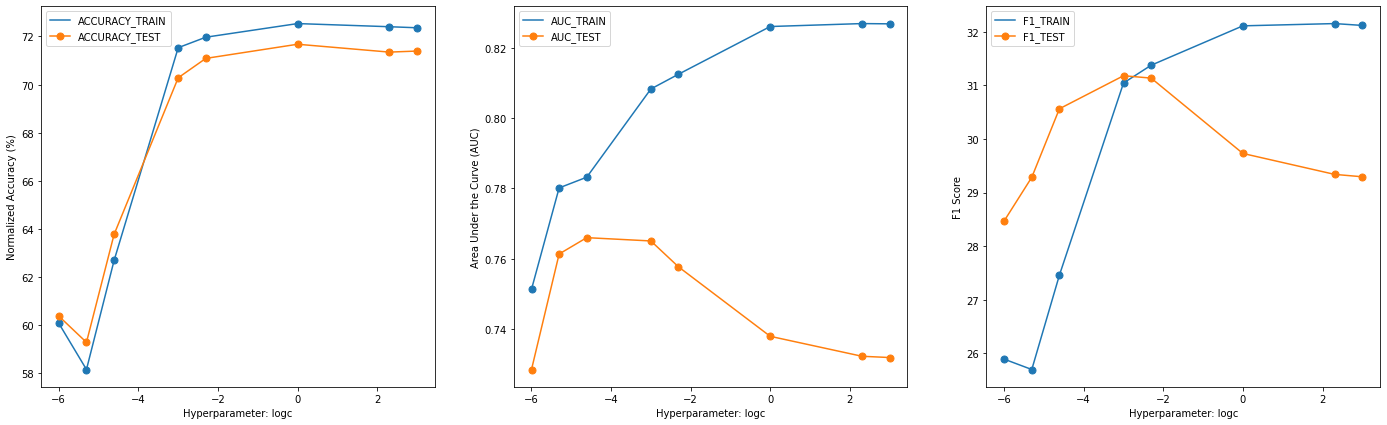

In [15]:
lr_performance_annual['logc'] = np.log(lr_performance_annual['C'])
plot_train_test_curves(lr_performance_annual,'logc')

In [16]:
lr_performance_annual

,C,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,logc
0,0.0025,60.069747,60.370370,25.889968,28.470311,0.173040,0.802661,0.751271,0.728438,-5.991465
1,0.0050,58.151700,59.281046,25.696594,29.284904,0.176551,0.858093,0.780110,0.761302,-5.298317
2,0.0100,62.685266,63.769063,27.457627,30.563674,0.188272,0.811530,0.783154,0.765955,-4.605170
3,0.0500,71.534438,70.283224,31.045407,31.180626,0.201829,0.685144,0.808258,0.765016,-2.995732
4,0.1000,71.970357,71.089325,31.376734,31.136482,0.203252,0.665188,0.812457,0.757648,-2.302585
5,1.0000,72.537053,71.677560,32.112069,29.729730,0.196569,0.609756,0.826030,0.737881,0.000000
6,10.0000,72.406277,71.350763,32.154341,29.339065,0.193617,0.605322,0.826869,0.732205,2.302585
7,20.0000,72.362685,71.394336,32.119914,29.294561,0.193457,0.603104,0.826793,0.731842,2.995732


By looking at the accuracy curves, it clearly shows that accuracy is relatively higher when C >= 0.05. AUC curves and F1 scores for both training and test dataset shows that the F1 score for test set is higher and AUC score is relatively higher when C=0.1. Therefore, I selected 0.1 as the best C for this logistic regression model.

In [34]:
#5. Plot coeffcient values or feature importance.
def lr(X_train, X_test, y_train, y_test, X, best_param):
    best_model = LogisticRegression(penalty='l1',solver='liblinear', C=best_param, class_weight='balanced',random_state=1147)
    best_model.fit(X_train, y_train)
    m = best_model.coef_
    
    indices = np.argsort(abs(m[0]))[::-1]
    names = [X.columns[i] for i in indices]
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]} ')
 
    #plot coefficient values 
    plt.figure(figsize=(16,7)) 
    plt.bar(range(X.shape[1]), m[0])
    plt.title("Coefficient values")
    plt.xticks(range(X.shape[1]), X.columns, rotation=90,size=7)
    plt.show()
 
    #prediction and predicted probability 
    y_test_pred = best_model.predict(X_test) 
    y_test_prob = best_model.predict_proba(X_test) 
   
    #scores for ROC curves 
    scores_train = best_model.predict_proba(X_train)[:, 1]
    scores_test = best_model.predict_proba(X_test)[:, 1] 
        
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are: 8:ann_txn_amt_cnt_2014, 32:ann_txn_amt_sum_2013 


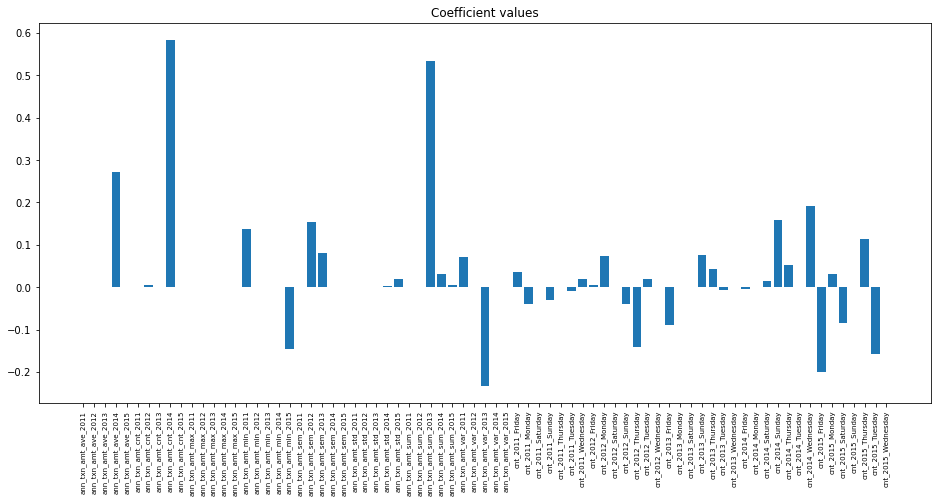

In [35]:
best_model, y_test_pred, y_test_prob, scores_train, scores_test = lr(X_train_annual_scaled, X_test_annual_scaled, y_train_annual, y_test_annual, X_train_annual, 0.1)

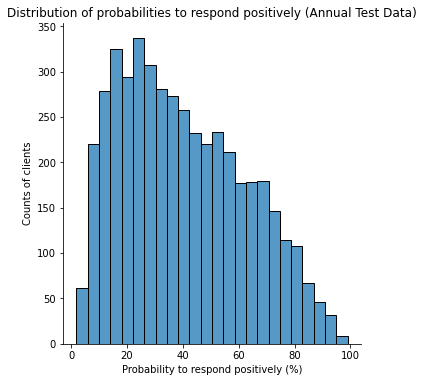

In [29]:
# 6.Plot probability distribution for test set
sns.displot(data = y_test_prob[:,1], x = 100 * y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively (Annual Test Data)')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

In [20]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
def plot_confusion_matrix(y_test, y_test_predicted):
 
    cm = confusion_matrix(y_test, y_test_predicted)
 
    precision = cm[1,1]/cm.sum(axis=0)[1]
    recall = cm[1,1]/cm.sum(axis=1)[1]
 
    print('Precision:', precision)
    print('Recall', recall)
 
    classNames = ['Negative','Positive']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

Precision: 0.2032520325203252
Recall 0.6651884700665188


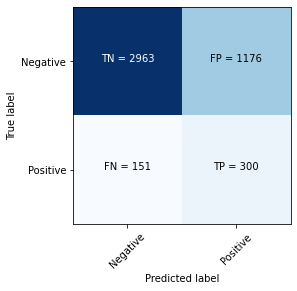

In [30]:
plot_confusion_matrix(y_test_annual.values, y_test_pred)

In [21]:
def plot_roc(y_train, scores_train, y_test, scores_test, model_name):
 
    fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test  = auc(fpr_test, tpr_test)
 
    # Plotting
    plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test))
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
    plt.ylim([0,1.0])
    plt.xlim([0,1.0])
    plt.title('{} ROC curves'.format(model_name))
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()

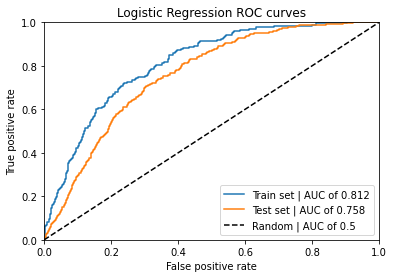

In [31]:
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Logistic Regression')

In [165]:
# 8. Plot decision boundary for top 2 features.
def plot_decision_boundary(best_model, feat1, feat2, X_train_scaled, X, y_train):
    #print('Top 2 features are:',X.columns[[feat1, feat2]])
    min_value1, min_value2 = np.floor(X_train_scaled.min(axis=0)[[feat1, feat2]])
    max_value1, max_value2 = np.ceil(X_train_scaled.max(axis=0)[[feat1, feat2]])

    step1, step2 = (max_value1-min_value1)/10, (max_value2-min_value2)/10
    xx, yy = np.mgrid[min_value1:max_value1:step1, min_value2:max_value2:step2]
    grid = np.c_[xx.ravel(), yy.ravel()]
    median_inputs = np.ones((100, X.shape[1])) * np.median(X_train_scaled, axis=0)
    median_inputs[:,feat1] = grid[:,0]
    median_inputs[:,feat2] = grid[:,1]
 
    probs = best_model.predict_proba(median_inputs)[:, 1].reshape(xx.shape)
 
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    ax.scatter(X_train_scaled[50:,feat1], X_train_scaled[50:,feat2], c=y_train[50:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)
 
    ax.set(aspect="auto", xlim=(min_value1, max_value1), ylim=(min_value2, max_value2),
           xlabel=f"{X.columns[feat1]}", ylabel=f"{X.columns[feat2]}")

Top 2 features are: Index(['ann_txn_amt_cnt_2014', 'ann_txn_amt_sum_2013'], dtype='object')


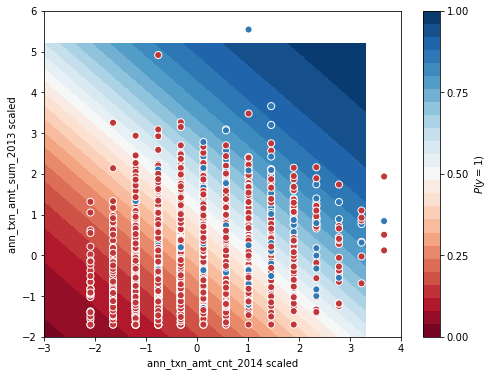

In [36]:
plot_decision_boundary(best_model, 8, 32, X_train_annual_scaled, X_train_annual, y_train_annual)

*   Decision Tree

In [53]:
def find_best_dt(X_train, y_train, X_test, y_test): 

    max_depth_range = range(2, 11) 
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[] 
 
    for i in max_depth_range: 
        # Define and fit\n",
        estimator_max_depth.append(DecisionTreeClassifier(max_depth = i, random_state=1147, class_weight='balanced')) 
        estimator_max_depth[i-2].fit(X_train, y_train) 
 
        # Score train and test set  
        scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1]  
 
        # Predict the class of train and test set 
        y_train_predicted = estimator_max_depth[i-2].predict(X_train) 
        y_test_predicted = estimator_max_depth[i-2].predict(X_test) 
 
        # Calculate training and test accuracy at every iteration and append 
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True)) 
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True)) 
 
        # Calculate training and test F1 score at every iteration and append 
        f1_train.append(100*f1_score(y_train, y_train_predicted)) 
        f1_test.append(100*f1_score(y_test, y_test_predicted)) 
 
        # Calculate precision and recall 
        precisions.append(precision_score(y_test, y_test_predicted)) 
        recalls.append(recall_score(y_test, y_test_predicted)) 
 
        # ROC Calc Train and test set  
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train) 
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test) 
 
        # Calculate the AUCs 
        auc_train.append(auc(fpr_train, tpr_train)) 
        auc_test.append(auc(fpr_test, tpr_test)) 
 
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train,  
                              'ACCURACY_TEST': accuracy_test, 
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test, 
                              'PRECISION': precisions, 
                              'RECALL': recalls, 
                              'AUC_TRAIN': auc_train, 
                              'AUC_TEST': auc_test} 
    performance_df = pd.DataFrame(performance_dictionary)
    performance_df.insert(0, 'MAX_DEPTH', value = max_depth_range ) 
    return performance_df

In [54]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
#for tree algorithms, we don't need to scale data
dt_performance_annual = find_best_dt(X_train_annual, y_train_annual, X_test_annual, y_test_annual)

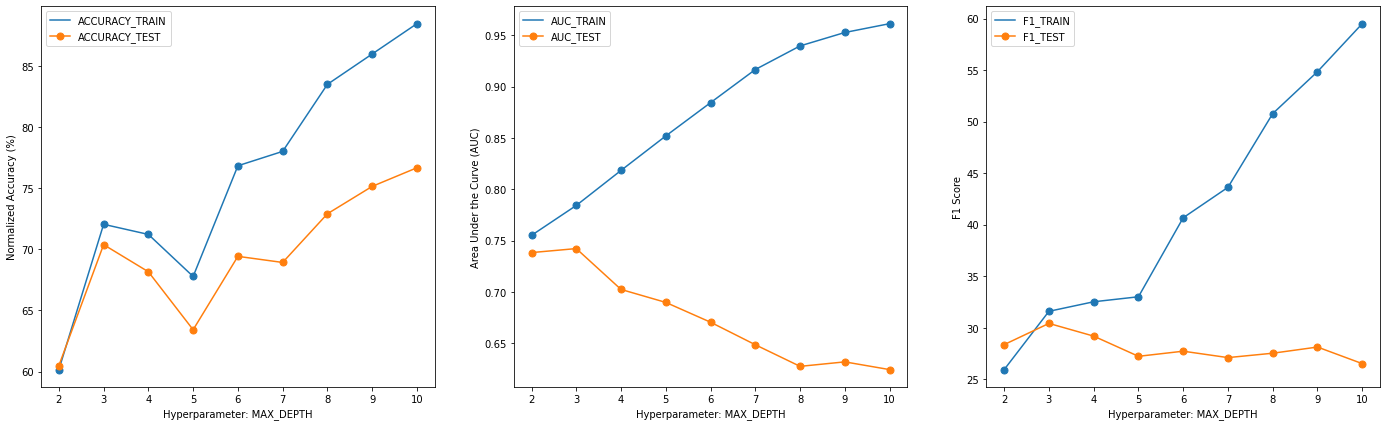

In [55]:
plot_train_test_curves(dt_performance_annual,'MAX_DEPTH')

In [56]:
dt_performance_annual

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,60.156931,60.479303,25.931929,28.357030,0.172513,0.796009,0.755100,0.738316
1,3,72.057541,70.392157,31.590181,30.414747,0.197736,0.658537,0.784239,0.742226
2,4,71.229294,68.169935,32.515337,29.180805,0.186725,0.667406,0.818369,0.702421
3,5,67.785527,63.420479,33.000907,27.221500,0.169181,0.696231,0.851948,0.689792
4,6,76.852659,69.433551,40.670391,27.717671,0.180537,0.596452,0.884363,0.670500
5,7,78.029643,68.932462,43.624161,27.096115,0.176080,0.587583,0.916638,0.648549
6,8,83.522232,72.919390,50.781250,27.521866,0.186709,0.523282,0.939633,0.627504
7,9,86.006975,75.163399,54.852321,28.121059,0.196476,0.494457,0.952722,0.631862
8,10,88.491718,76.688453,59.509202,26.510989,0.192040,0.427938,0.961312,0.624342


Based on AUC and F1 scores, the test AUC and F1 both reach the maximum when max_depth is 3. So I choose max_depth = 3.

In [58]:
def dt(X_train, X_test, y_train, y_test, X, best_param): 
 
    best_model = DecisionTreeClassifier(max_depth=best_param, random_state=0, class_weight='balanced') 
    best_model.fit(X_train, y_train) 
    importances = best_model.feature_importances_ 
    
    indices = np.argsort(abs(importances))[::-1]
    names = [X.columns[i] for i in indices]
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]} ')
 
    names = [X.columns[i] for i in indices] 
    plt.figure(figsize=(16,5)) 
    plt.title("Feature Importance") 
    plt.bar(range(X.shape[1]), importances[indices]) 
    plt.xticks(range(X.shape[1]), names, rotation=90) 
    plt.show()
 
    #prediction and predicted probability 
    y_test_pred = best_model.predict(X_test) 
    y_test_prob = best_model.predict_proba(X_test) 
 
    #scores for ROC curves 
    scores_train = best_model.predict_proba(X_train)[:, 1] 
    scores_test = best_model.predict_proba(X_test)[:, 1] 
 
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are: 33:ann_txn_amt_sum_2014, 32:ann_txn_amt_sum_2013 


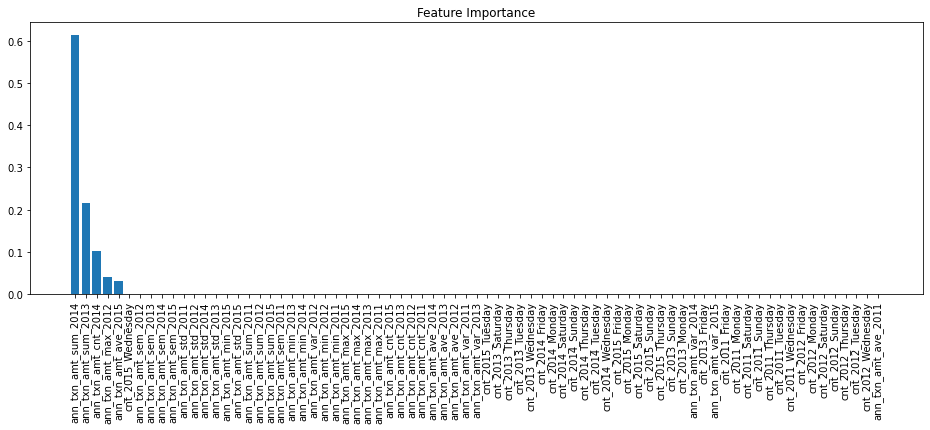

In [59]:
#5. Plot coeffcient values or feature importance.
best_model, y_test_pred, y_test_prob, scores_train, scores_test = dt(X_train_annual, X_test_annual, y_train_annual, y_test_annual, X_train_annual,3)

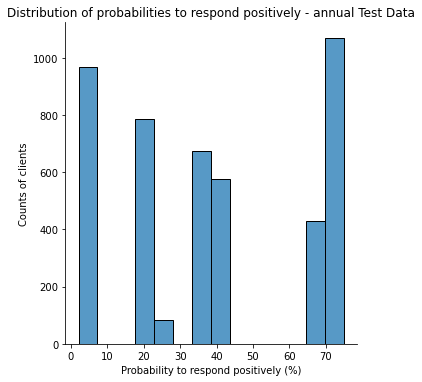

In [60]:
# 6.Plot probability distribution for test set
sns.displot(data = y_test_prob[:,1], x = 100*y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively - annual Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

Precision: 0.1977363515312916
Recall 0.6585365853658537


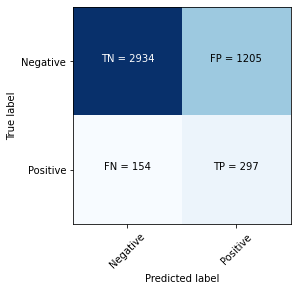

In [62]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
plot_confusion_matrix(y_test_annual.values, y_test_pred)

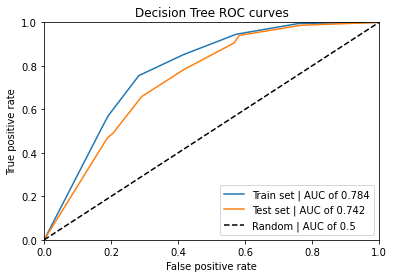

In [63]:
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Decision Tree')

Top 2 features are: Index(['ann_txn_amt_sum_2014', 'ann_txn_amt_sum_2013'], dtype='object')


/Users/qiuchenwang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


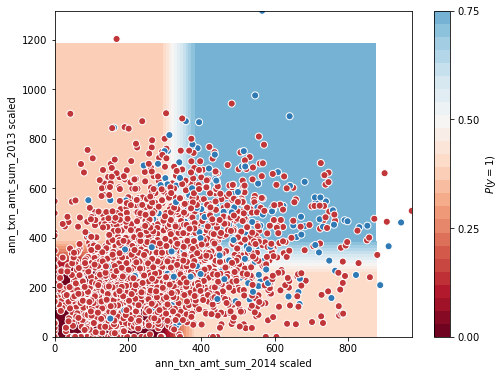

In [82]:
# 8. Plot decision boundary for top 2 features.
plot_decision_boundary(best_model, 33, 32, X_train_annual.values, X_train_annual, y_train_annual)

* Random Forests

In [158]:
def find_best_rf(X_train, y_train, X_test, y_test): 
 
    max_depth_range = range(2,20) 
    estimator_max_depth, accuracy_train, accuracy_test, precisions, recalls, f1_train, f1_test, auc_train, auc_test = [],[],[],[],[],[],[],[],[] 
 
    for i in max_depth_range: 
        # Define and fit 
        estimator_max_depth.append(RandomForestClassifier(max_depth = i,class_weight='balanced', random_state=1147)) 
        estimator_max_depth[i-2].fit(X_train, y_train) 
 
        # Score train and test set 
        scores_train = estimator_max_depth[i-2].predict_proba(X_train)[:,1] 
        scores_test  = estimator_max_depth[i-2].predict_proba(X_test)[:,1] 
 
        # Predict the class of test set 
        y_train_predicted = estimator_max_depth[i-2].predict(X_train) 
        y_test_predicted = estimator_max_depth[i-2].predict(X_test) 
 
        # Calculate training and test accuracy at every iteration and append 
        accuracy_train.append(100*accuracy_score(y_train, y_train_predicted, normalize = True)) 
        accuracy_test.append(100*accuracy_score(y_test, y_test_predicted, normalize = True)) 
 
        # Calculate training and test F1 score at every iteration and append 
        f1_train.append(100*f1_score(y_train, y_train_predicted)) 
        f1_test.append(100*f1_score(y_test, y_test_predicted)) 
 
        # Calculate precision and recall 
        precisions.append(precision_score(y_test, y_test_predicted)) 
        recalls.append(recall_score(y_test, y_test_predicted)) 
 
        # ROC Calc trianing and test dataset 
        fpr_train, tpr_train, _ = roc_curve(y_train, scores_train) 
        fpr_test, tpr_test, _ = roc_curve(y_test, scores_test) 
 
        # Calculate the AUCs 
        auc_train.append(auc(fpr_train, tpr_train)) 
        auc_test.append(auc(fpr_test, tpr_test)) 
 
 
    performance_dictionary = {'ACCURACY_TRAIN': accuracy_train, 
                              'ACCURACY_TEST': accuracy_test,  
                              'F1_TRAIN': f1_train, 
                              'F1_TEST': f1_test, 
                              'PRECISION': precisions, 
                              'RECALL': recalls, 
                              'AUC_TRAIN': auc_train, 
                              'AUC_TEST': auc_test} 
    performance_df = pd.DataFrame(performance_dictionary) 
    performance_df.insert(0, 'MAX_DEPTH', value = max_depth_range)  
    return performance_df

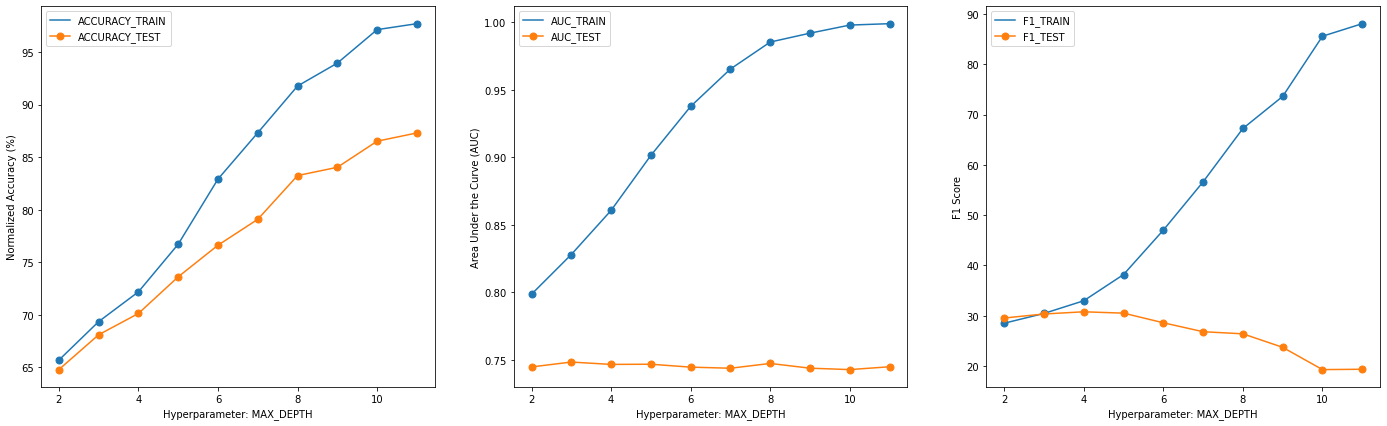

In [100]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
#for tree algorithms, we don't need to scale data
rf_performance_annual = find_best_rf(X_train_annual, y_train_annual, X_test_annual, y_test_annual)
plot_train_test_curves(rf_performance_annual,'MAX_DEPTH')

In [101]:
rf_performance_annual

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,65.693112,64.793028,28.519528,29.555362,0.183939,0.751663,0.798662,0.744882
1,3,69.354839,68.104575,30.464886,30.352046,0.193216,0.707317,0.828058,0.748484
2,4,72.188317,70.130719,32.983193,30.792529,0.199346,0.676275,0.860679,0.746746
3,5,76.721883,73.616558,38.194444,30.522088,0.205882,0.589800,0.901403,0.746880
4,6,82.911944,76.623094,47.027027,28.609448,0.204373,0.476718,0.937654,0.744728
5,7,87.314734,79.084967,56.631893,26.829268,0.204413,0.390244,0.965327,0.743917
6,8,91.761116,83.246187,67.244367,26.411483,0.232323,0.305987,0.985285,0.747458
7,9,93.940715,84.030501,73.624288,23.725286,0.223529,0.252772,0.991858,0.743945
8,10,97.122929,86.514161,85.589520,19.295958,0.234177,0.164080,0.997843,0.742905
9,11,97.689625,87.298475,88.089888,19.363762,0.257353,0.155211,0.998881,0.745005


Accuracy increases as max_depth increases. Auc curve almost remain the same. F1 scores are relatively higher when max_depth is 3 to 5. So based on the accuracy and F1 score, I choose max_depth = 5.

In [104]:
def rf(X_train, X_test, y_train, y_test, X,best_param): 
 
    best_model = RandomForestClassifier(max_depth = best_param, random_state=1147, class_weight='balanced') 
    best_model.fit(X_train, y_train) 
 
    #plot feature importance 
    importances = best_model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    names = [X.columns[i] for i in indices] 
    print(f'The indices for top 2 features are: {indices[0]}:{names[0]}, {indices[1]}:{names[1]}')
    plt.figure(figsize=(15,9)) 
    plt.title("Feature Importance") 
    plt.bar(range(X.shape[1]), importances[indices]) 
    plt.xticks(range(X.shape[1]), names, rotation=90) 
    plt.show() 
 
    #prediction and predicted probability 
    y_test_pred = best_model.predict(X_test) 
    y_test_prob = best_model.predict_proba(X_test) 
 
    #scores for ROC curves 
    scores_train = best_model.predict_proba(X_train)[:, 1] 
    scores_test = best_model.predict_proba(X_test)[:, 1] 
 
    return best_model, y_test_pred, y_test_prob, scores_train, scores_test

The indices for top 2 features are: 33:ann_txn_amt_sum_2014, 8:ann_txn_amt_cnt_2014


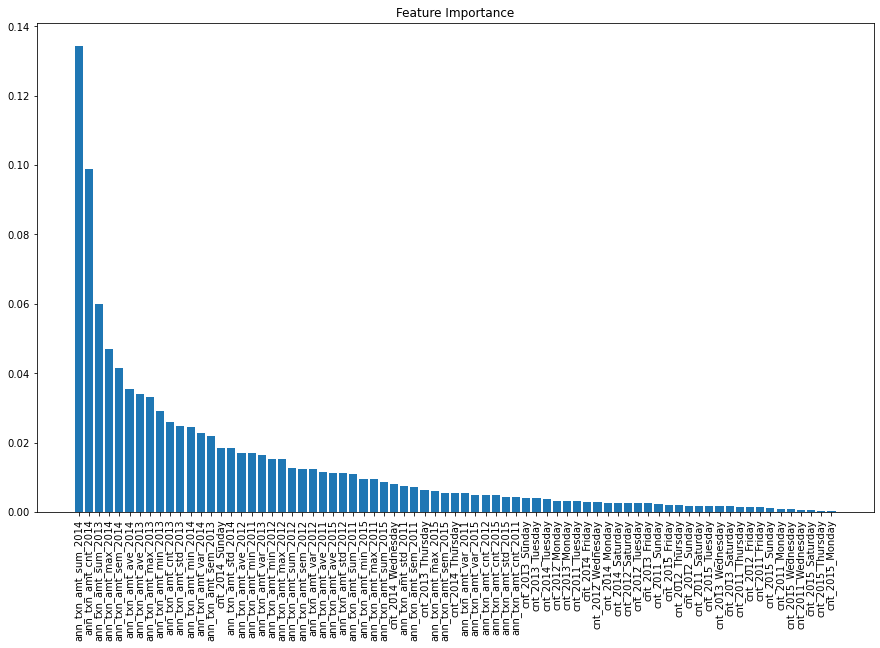

In [105]:
#5. Plot coeffcient values or feature importance.
best_model, y_test_pred, y_test_prob, scores_train, scores_test = rf(X_train_annual, X_test_annual, y_train_annual, y_test_annual, X_train_annual,5)

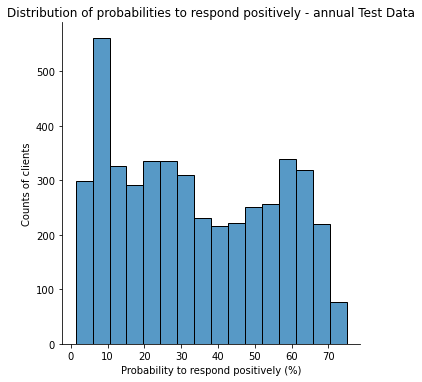

In [106]:
# 6.Plot probability distribution for test set
sns.displot(data = y_test_prob[:,1], x = 100*y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively - annual Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

Precision: 0.20588235294117646
Recall 0.5898004434589801


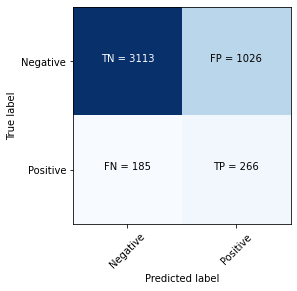

In [107]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
plot_confusion_matrix(y_test_annual.values, y_test_pred)

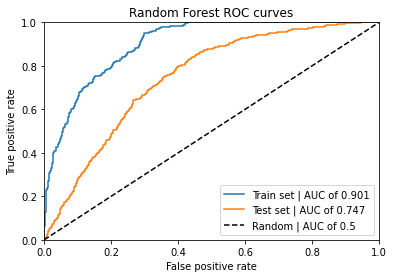

In [108]:
plot_roc(y_train_annual, scores_train, y_test_annual, scores_test, 'Random Forest')

/Users/qiuchenwang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


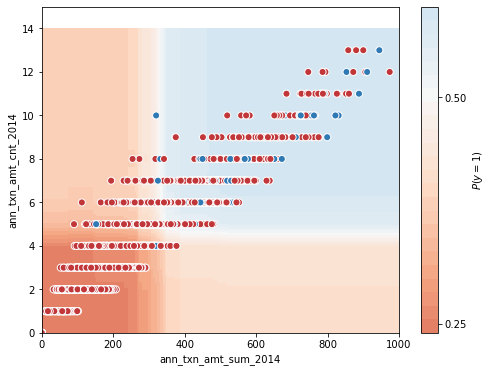

In [156]:
# 8. Plot decision boundary for top 2 features.
plot_decision_boundary(best_model, 33, 8, X_train_annual.values, X_train_annual, y_train_annual)

#### Part 2: Monthly Features

In [37]:
#1.Separate the inputs X and the output y in two data frames.
#drop CLNT_NO, ME_DT and response for X_annual
X_mth = mth_features_outputs.drop(['CLNT_NO', 'response', 'ME_DT'], axis = 1)
y_mth = mth_features_outputs['response']

In [38]:
#2.Split the data in train and test set.
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_mth, y_mth, test_size=2/3, random_state=1147)

In [39]:
#3.Pre-processing
scaler_monthly = StandardScaler()
X_train_monthly_scaled = scaler_monthly.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler_monthly.transform(X_test_monthly)

*   Logistic Regression with L1 regularization

In [40]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
lr_performance_monthly = find_best_lr(X_train_monthly_scaled, y_train_monthly, X_test_monthly_scaled, y_test_monthly)

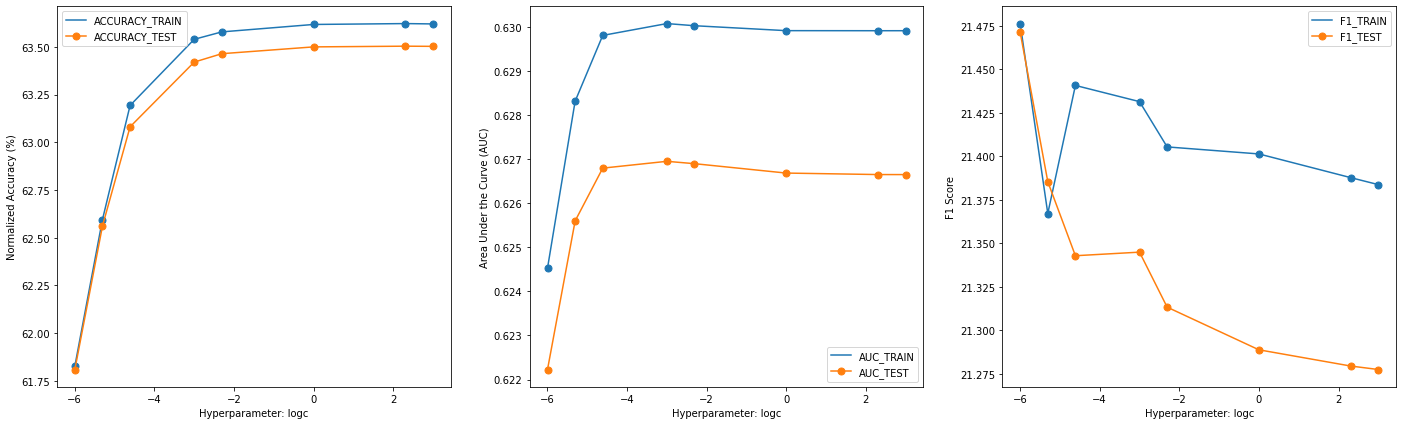

In [41]:
lr_performance_monthly['logc'] = np.log(lr_performance_monthly['C'])
plot_train_test_curves(lr_performance_monthly,'logc')

In [42]:
lr_performance_monthly

,C,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST,logc
0,0.0025,61.826257,61.808353,21.476254,21.471264,0.133119,0.554724,0.624527,0.622228,-5.991465
1,0.0050,62.594924,62.560791,21.367172,21.385460,0.133265,0.541030,0.628311,0.625596,-5.298317
2,0.0100,63.192983,63.080960,21.440728,21.342921,0.133482,0.532164,0.629803,0.626794,-4.605170
3,0.0500,63.539764,63.420322,21.431426,21.344977,0.133805,0.527337,0.630071,0.626948,-2.995732
4,0.1000,63.578707,63.464365,21.405418,21.313391,0.133661,0.525712,0.630022,0.626895,-2.302585
5,1.0000,63.617651,63.500063,21.401386,21.288891,0.133552,0.524431,0.629911,0.626682,0.000000
6,10.0000,63.622287,63.503771,21.387781,21.279574,0.133501,0.524086,0.629909,0.626648,2.302585
7,20.0000,63.620432,63.502844,21.383774,21.277574,0.133488,0.524037,0.629909,0.626647,2.995732


0.05

The indices for top 2 features are: 15:amt_mean_12M, 14:amt_sum_12M 


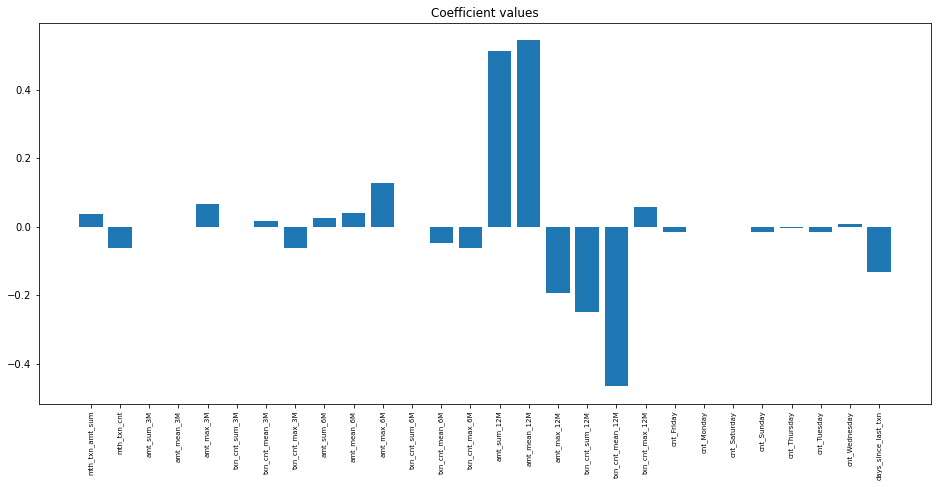

In [43]:
#5. Plot coeffcient values or feature importance.
best_model, y_test_pred, y_test_prob, scores_train, scores_test = lr(X_train_monthly_scaled, X_test_monthly_scaled, y_train_monthly, y_test_monthly, X_train_monthly, 0.05)

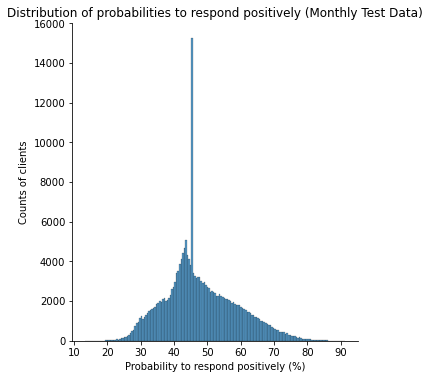

In [46]:
# 6.Plot probability distribution for test set
sns.displot(data = y_test_prob[:,1], x = 100 * y_test_prob[:,1])
plt.title('Distribution of probabilities to respond positively (Monthly Test Data)')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

Precision: 0.1338049292606109
Recall 0.5273372081568318


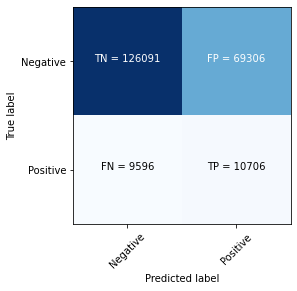

In [45]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

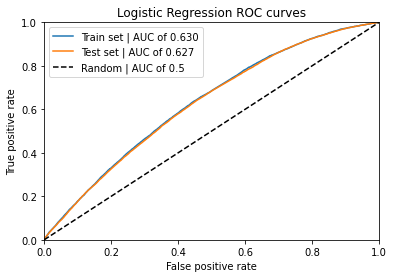

In [47]:
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Logistic Regression')

Top 2 features are: Index(['amt_mean_12M', 'amt_sum_12M'], dtype='object')


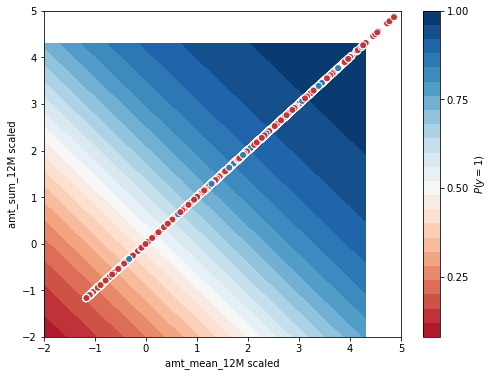

In [48]:
# 8. Plot decision boundary for top 2 features.
plot_decision_boundary(best_model, 15, 14, X_train_monthly_scaled, X_train_monthly, y_train_monthly)

*   Decision Tree

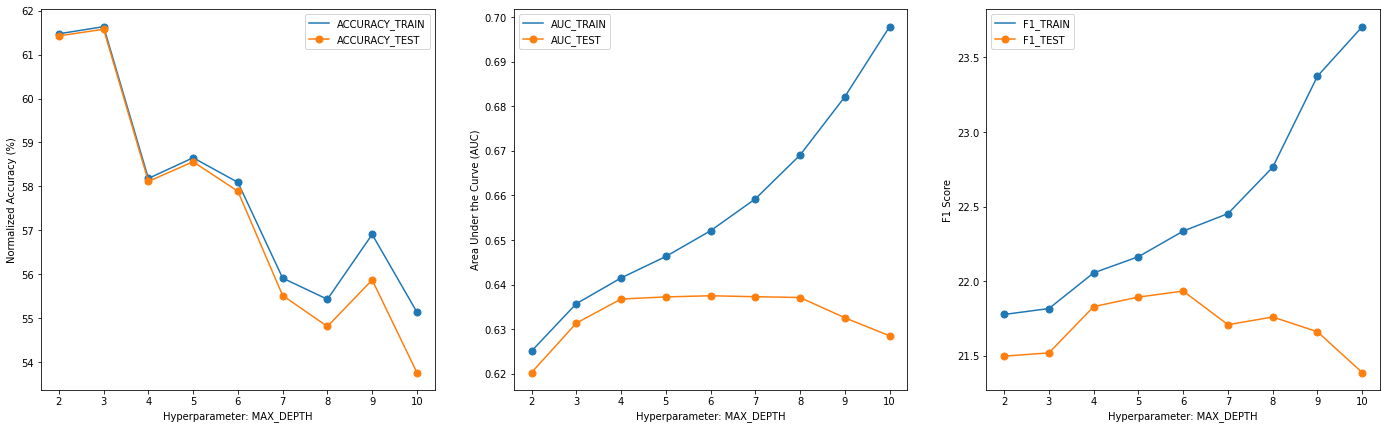

In [83]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
dt_performance_monthly = find_best_dt(X_train_monthly, y_train_monthly, X_test_monthly, y_test_monthly)
plot_train_test_curves(dt_performance_monthly,'MAX_DEPTH')

In [84]:
dt_performance_monthly

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,61.472058,61.424485,21.777108,21.497646,0.132954,0.561176,0.625082,0.620261
1,3,61.634322,61.576085,21.816601,21.519611,0.133206,0.559699,0.635699,0.631349
2,4,58.182273,58.114317,22.055926,21.829603,0.132406,0.621367,0.641477,0.636744
3,5,58.652375,58.562163,22.164040,21.893651,0.133078,0.617033,0.646289,0.637231
4,6,58.093260,57.889930,22.335636,21.933632,0.132849,0.628510,0.652061,0.637487
5,7,55.915215,55.518106,22.452741,21.708513,0.130094,0.655206,0.659198,0.637274
6,8,55.433059,54.815739,22.763574,21.760003,0.129985,0.667570,0.669029,0.637092
7,9,56.909197,55.873231,23.373840,21.661084,0.130033,0.648163,0.682099,0.632549
8,10,55.140984,53.765664,23.705292,21.387525,0.127312,0.668210,0.697814,0.628507


F1 scores are relatively high when max_depth is 4 to 6. Among 4 to 6, accuracy is higher when max_depth is 5. So here, I choose max_depth = 5.

The indices for top 2 features are: 15:amt_mean_12M, 16:amt_max_12M 


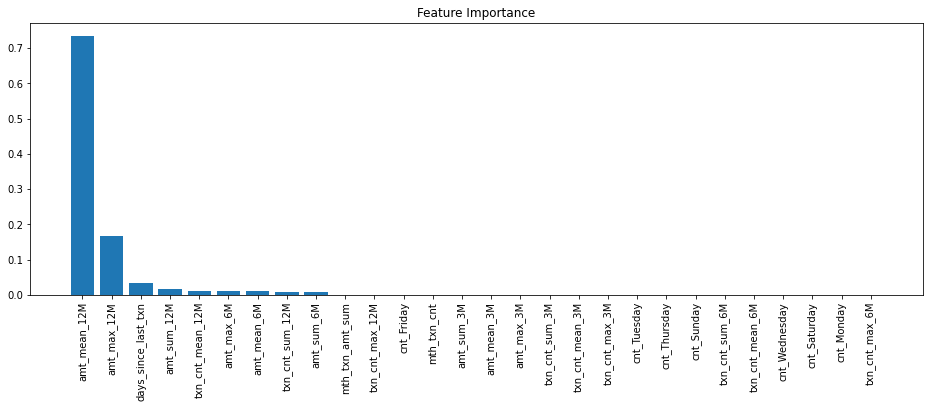

In [172]:
#5. Plot coeffcient values or feature importance.
best_model, y_test_pred, y_test_prob, scores_train, scores_test = dt(X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly, X_train_monthly,5)

Text(0, 0.5, 'Counts of clients')

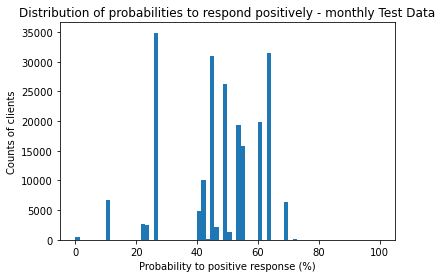

In [173]:
# 6. Plot probability distribution for test set
plt.hist(100*y_test_prob[:,1], bins=70)
plt.title('Distribution of probabilities to respond positively - monthly Test Data')
plt.xlabel('Probability to positive response (%)')
plt.ylabel('Counts of clients')

Precision: 0.13307766670561866
Recall 0.6170328046497882


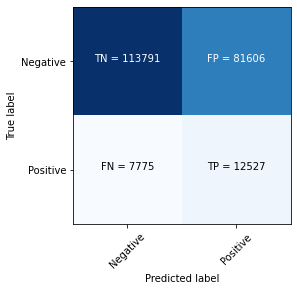

In [174]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

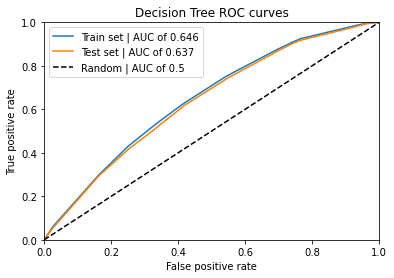

In [175]:
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Decision Tree')

Top 2 features are: Index(['amt_mean_12M', 'amt_max_12M'], dtype='object')


/Users/qiuchenwang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


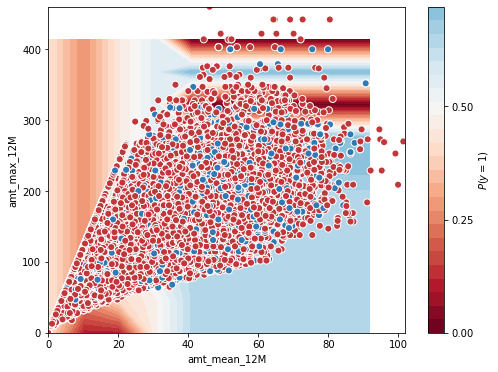

In [177]:
# 8. Plot decision boundary for top 2 features.
plot_decision_boundary(best_model, 15, 16, X_train_monthly.values, X_train_monthly, y_train_monthly)

* Random Forests

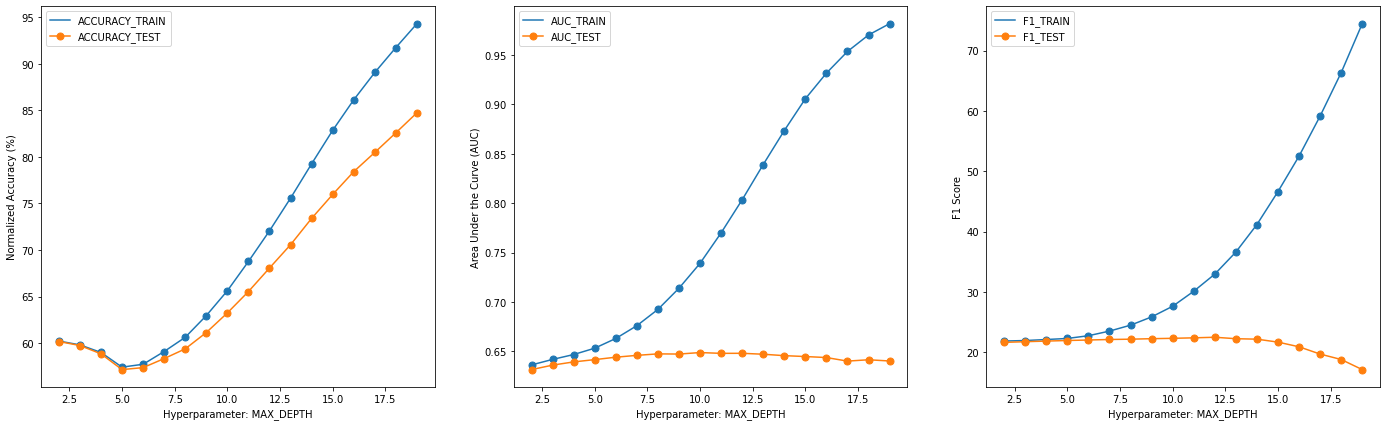

In [159]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
#for tree algorithms, we don't need to scale data
rf_performance_monthly = find_best_rf(X_train_monthly, y_train_monthly, X_test_monthly, y_test_monthly)
plot_train_test_curves(rf_performance_monthly,'MAX_DEPTH')

In [160]:
rf_performance_monthly

,MAX_DEPTH,ACCURACY_TRAIN,ACCURACY_TEST,F1_TRAIN,F1_TEST,PRECISION,RECALL,AUC_TRAIN,AUC_TEST
0,2,60.219381,60.171350,21.848188,21.626405,0.132712,0.583834,0.636381,0.631647
1,3,59.811403,59.741121,21.931231,21.736544,0.133022,0.593981,0.641953,0.636168
2,4,58.996375,58.848210,22.097735,21.839283,0.132967,0.610827,0.646878,0.639419
3,5,57.419169,57.154646,22.276381,21.935211,0.132378,0.639543,0.653305,0.641742
4,6,57.727007,57.367906,22.728428,22.018131,0.132986,0.639444,0.663122,0.644188
5,7,59.098369,58.338240,23.496358,22.103949,0.134123,0.628017,0.676054,0.646048
6,8,60.623650,59.382751,24.477601,22.154694,0.135154,0.614077,0.692525,0.647555
7,9,62.952832,61.135193,25.848598,22.238301,0.136990,0.590434,0.713941,0.647373
8,10,65.623232,63.242296,27.614752,22.297575,0.139180,0.560339,0.739153,0.648886
9,11,68.767443,65.536233,30.104582,22.378615,0.141994,0.527830,0.769955,0.648084


Accuracy increases as max_depth increases. Auc curve almost remain the same for test set. F1 scores are relatively higher when max_depth is 6 to 14. So based on the accuracy and F1 score, I choose max_depth = 14.

The indices for top 2 features are: 14:amt_sum_12M, 15:amt_mean_12M


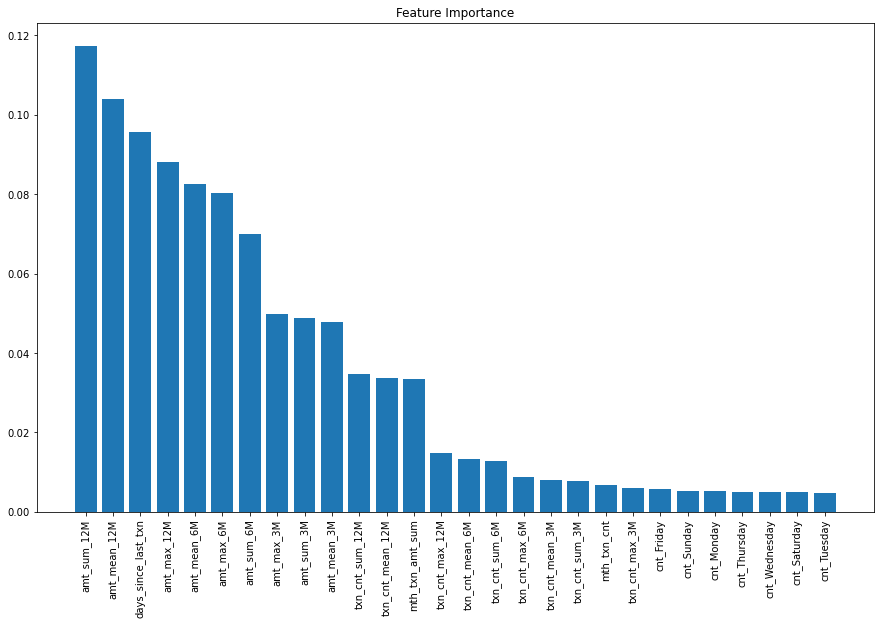

In [161]:
#5. Plot coeffcient values or feature importance.
best_model, y_test_pred, y_test_prob, scores_train, scores_test = rf(X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly, X_train_monthly,14)

Precision: 0.15289712627539082
Recall 0.4022756378681903


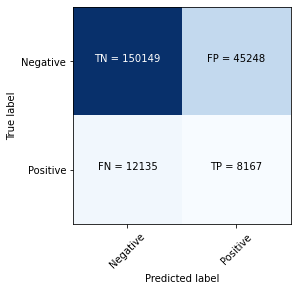

In [162]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
plot_confusion_matrix(y_test_monthly.values, y_test_pred)

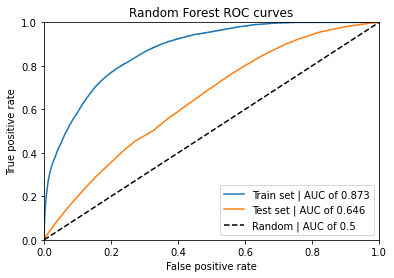

In [163]:
plot_roc(y_train_monthly, scores_train, y_test_monthly, scores_test, 'Random Forest')

/Users/qiuchenwang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


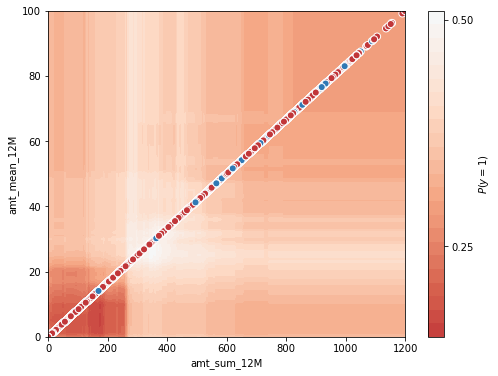

In [171]:
# 8. Plot decision boundary for top 2 features.
plot_decision_boundary(best_model, 14, 15, X_train_monthly.values, X_train_monthly, y_train_monthly)

### 1.3 Comparison of methods (10 points)

> Compare the two feature engineering (annual and monthly) and the three modeling approaches (L1 log-reg, tree, forests) in terms of the outcomes of steps 5-8. Which combination of feature engineering and modeling approach do you select as the best to deploy in a
production environment and why? Tabularize your findings in steps 5-8 to summarize the
results and support your decision (how to organize information with tables in Markdown).

|Annual|Monthly|
| ---------------- | ----------- |
|X_train_annual  y_train_annual| X_train_monthly  y_train_monthly|
|X_test_annual  y_test_annual|X_test_monthly  y_test_monthly|

Precision: 0.2032520325203252
Recall 0.6651884700665188

|Feature|Model|precision|recall|Test Accuracy|Test set Probability distribution|Testing AUC|Training AUC|
| ---------------- | ----------- |----------- |----------- |----------- |----------- |----------- |----------- |
|Annual|L1 lr|0.203|0.665|0.711|lot of clients has probability to respond positively between 10% - 50%|0.812|0.758|
||Tree|0.20|	0.33|	0.8009|	some clients has probability to respond positively between 55% - 80%|	0.694|	0.803|
||Forests|	0.21|	0.09|	0.8765|	some clients has probability to respond positively between 50% - 65%|	0.753|	0.914|
|Monthly|	L1 lr|	0.15|	0.22|	0.8110|	some clients has probability to respond positively between 50% - 70%|	0.626|	0.63|
||Tree|	0.00|	0.00|	0.9059|	no client has probability to respond positively > 40%|	0.619|	0.625|
||Forests|	0.00|	0.00|	0.9059|	no client has probability to respond positively > 40%|	0.632|	0.638|